# Signature Analysis After CPTAC2 Artifact Filtering

## 1 Setup/Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2
# Import packages
import pandas as pd
import numpy as np
import signatureanalyzer as sa
from twobitreader import TwoBitFile
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics.pairwise import cosine_similarity
import os
import itertools

import sys
sys.path.append("../funcs")
import plotting as pl
import ms_utils
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
import plotnine
from plotnine import ggplot, geom_point, geom_violin, geom_boxplot, geom_jitter
from plotnine import aes, stat_smooth, facet_wrap, scale_fill_manual, theme_bw, element_blank
from plotnine import guides, theme, labs, element_text, guide_legend

import rpy2.rinterface
%load_ext rpy2.ipython

In [2]:
# Define file paths
MAF_PATH = "gs://cptac-pancan-getzlab/Freeze_050721/Somatic_WXS/union_somatic_maf_v1.1_hotspot_cptac2fix.maf"
SAMPLE_MAP_PATH = "gs://cptac-pancan-getzlab/Final_Submission_Files/PanCan_Participant_freeze_mapping.tsv"

HG38_2BIT = "../analysis_files/mutational_signatures/hg38.2bit"

SIG_OUTPUT = "../results/mutational_signatures/"

In [3]:
# Load sample map
sample_map = pd.read_csv(SAMPLE_MAP_PATH, sep='\t')
sample_map.index = sample_map.index.astype(str)

# Import MAF
agg_maf = pd.read_csv(MAF_PATH, sep='\t')

/home/yakiyama/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (23,61,74,76,80,81,89,119) have mixed types.Specify dtype option on import or set low_memory=False.


In [18]:
# Identify POLE/POLD-exo* samples
pole, pold = sa.utils.get_pole_pold_muts(agg_maf.rename(columns={"Protein_Change":"HGVSp_Short"}))

POLE-exo* patients:
['11CO070_T' '17OV002_T' '20CO003_T' 'C3L-00156_T' 'C3L-00586_T'
 'C3L-00601_T' 'C3L-00770_T' 'C3L-01311_T' 'C3N-00151_T' 'C3N-00328_T'
 'C3N-01200_T']
POLD-exo* patients:
['09CO015_T' 'C3N-00556_T']
POLE-exo* + POLD-exo* patients:
[]


In [29]:
# Tumor type mapping
cohort_df = sample_map.copy()
cohort_df = cohort_df[cohort_df['cohort'] != 'MEDUL']
cohort_df = cohort_df[['WXS','cohort']].rename(columns={'WXS':'sample'})
cohort_d = cohort_df.set_index('sample').to_dict()['cohort']
cohort_l = list(cohort_df['cohort'].unique())

## 2. Identify MMRD tumors

1) Identify POLE-exo* and POLD1-exo* mutants and separate from the rest of the samples

2) On all non-POLE/POLD1-exo* Mutational signatures using composite (96 SBS + 78 DBS + 83 ID) spectra. 

3) Using the distribution of MMRD-related mutational signature weights, classify MMRD tumors

In [11]:
# Remove POLE/POLD-exo* from maf
sub_maf_df = agg_maf[~agg_maf['Tumor_Sample_Barcode'].isin(pole+pold)]

# Create mutational spectra
_, sub_spec_composite = sa.spectra.get_spectra_from_maf(sub_maf_df, 
                                                        hgfile=HG38_2BIT,
                                                        reference="pcawg_COMPOSITE96")

sub_spec_composite.to_csv(
    "../analysis_files/Non_POLE_POLD/non_pole_pold_composite96_c2a_filtered.tsv", 
    sep='\t'
)


In [6]:
# Run mutational signatures
!signatureanalyzer ../spectra/Non_POLE_POLD/non_pole_pold_composite96_c2a_filtered.tsv \
-t spectra \
-n 100 \
--max_iter 30000 \
--objective poisson \
--prior_on_H L1 --prior_on_W L1 \
-o ../results/mutational_signatures/Non_POLE_POLD/non_pole_pold_composite96_c2a_filtered \
--reference pcawg_COMPOSITE96


---------------------------------------------------------
---------- S I G N A T U R E  A N A L Y Z E R  ----------
---------------------------------------------------------
   * Creating output dir at ../results/mutational_signatures/Non_POLE_POLD/non_pole_pold_composite96_c2a_filtered
   * Using pcawg_COMPOSITE96 signatures
   * Saving ARD-NMF outputs to ../results/mutational_signatures/Non_POLE_POLD/non_pole_pold_composite96_c2a_filtered/nmf_output.h5
   * Running ARD-NMF...
	0/99: nit= 4886 K=6 	del=0.0000000053
	1/99: nit= 7219 K=6 	del=0.0000000018
	2/99: nit= 4033 K=6 	del=0.0000000088
	3/99: nit= 4118 K=6 	del=0.0000000068
	4/99: nit= 2856 K=6 	del=0.0000000033
	5/99: nit= 4725 K=6 	del=0.0000000062
	6/99: nit= 4315 K=6 	del=0.0000000081
	7/99: nit= 6176 K=6 	del=0.0000000037
	8/99: nit= 2426 K=6 	del=0.0000000083
	9/99: nit= 5250 K=6 	del=0.0000000020
	10/99: nit= 5150 K=6 	del=0.0000000080
	11/99: nit= 7264 K=6 	del=0.0000000060
	12/99: nit= 3733 K=6 	del=0.0000000088
	13/99:

In [35]:
# Check cosine similarity
cosine_df = pd.read_hdf(
    "../results/mutational_signatures/Non_POLE_POLD/non_pole_pold_composite96_c2a_filtered/nmf_output.h5", 
    "cosine")
cosine_df.apply(lambda x: x.loc[x.idxmax()]), cosine_df.apply(lambda x: x.idxmax())

S1-SBS74_S    0.989776
S2-SBS39_P    0.756066
S3-SBS15_S    0.822123
S4-SBS4_P     0.929577
S5-SBS7b_S    0.944402
S6-SBS13_P    0.934112
dtype: float64

In [11]:
# Threshold MMRD
h_df = pd.read_hdf(
    "../results/mutational_signatures/Non_POLE_POLD/non_pole_pold_composite96_c2a_filtered/nmf_output.h5", "H")
h_norm_df = h_df.copy().drop(columns=['max', 'max_id', 'max_norm'])
h_norm_df = h_norm_df.div(h_norm_df.sum(1), 0)

Raw signature attribution threshold: 72.59769439697266
Fractional attribution threshold: 0.19529545824868053


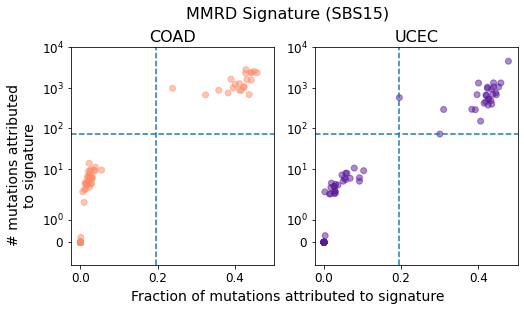

In [13]:
# Subset for COAD and UCEC tumors
plot_df = ms_utils.prep_plotting_df(
    h_df[h_df.index.map(lambda x: cohort_d[x] in ['COAD','UCEC'])],
    color_scheme=pl.CPTAC_CMAP, cohort_df=cohort_df, 
    signature='S3-SBS15_S'
)
plot_df = plot_df.sort_values('cohort')

mmrd_norm_thresh = plot_df[plot_df['norm']>= 0.15].sort_values('norm').iloc[0]['norm']
mmrd_raw_thresh = plot_df[plot_df['norm']>= 0.15].sort_values('raw').iloc[0]['raw']
figure, ax = ms_utils.plot_norm_raw_sigs(plot_df,raw_thresh = mmrd_raw_thresh, 
                                         norm_thresh = mmrd_norm_thresh, 
                                         show_raw_thresh=True, 
                                         show_norm_thresh=True, sharey=False,
                                         title='MMRD Signature (SBS15)', height=4, width=8, 
                                         plot_all=False, xlabel_coords=(0.5, 0),
                                         ylabel_coords=(0.04, 0.2),
                                         fig_suptitle_ycoord=1.02, 
                                         ylabel="# mutations attributed\nto signature", 
                                         show_legend=False, fig_suptitle_size=16, 
                                         xlabel_size=14, ylabel_size=14)
ax[0].set_title("COAD", size=16, fontname='Arial')
ax[1].set_title("UCEC", size=16, fontname='Arial')
ax[0].tick_params(axis='y', labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)
ax[0].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='x', labelsize=12)
ax[0].set_yscale('symlog')
ax[1].set_yscale('symlog')
ax[0].set_ylim((-1, 1e4))
ax[1].set_ylim((-1, 1e4))

figure.savefig("figures/Figure_S3B_signature_cutoff_MMRD.pdf",
               dpi=100, bbox_inches='tight')

print(f"Raw signature attribution threshold: {mmrd_raw_thresh}")
print(f"Fractional attribution threshold: {mmrd_norm_thresh}")

Establish an MMRD threshold of 72 mutations and 20% of mutations attributed to SBS15_S based on the minimum contributions in UCEC and COAD samples with moderate signature contributions.

Figure S3B

In [15]:
PanCan_MMRD_raw = h_df[(h_df['S3-SBS15_S'] >= mmrd_raw_thresh) &
                       (h_norm_df['S3-SBS15_S'] >= mmrd_norm_thresh)
                      ].index.to_list()
PanCan_MMRD_norm = h_norm_df[h_norm_df['S3-SBS15_S'] >= mmrd_norm_thresh].index.to_list()
PanCan_MMRD = list(np.intersect1d(PanCan_MMRD_norm, PanCan_MMRD_raw))
print(f"# MMRD tumors: {len(PanCan_MMRD)}")

# MMRD tumors: 57


## 2 Construct Mutational Spectra

In [29]:
# List of mismatch repair, POLE, and POLD1 proficient tumors
PanCan_MMRP = [x for x in agg_maf['Tumor_Sample_Barcode'].unique() if 
               x not in PanCan_MMRD + list(pole) + list(pold)]

In [35]:
# Aggregate POLE/POLD-exo* spectra (96 SBS + ID)
pole_pold_maf = agg_maf[agg_maf['Tumor_Sample_Barcode'].isin(list(pole)+list(pold))]
_, pole_pold_spec_pole_msi96 = sa.spectra.get_spectra_from_maf(pole_pold_maf,
                                                               hgfile="../hg38.2bit",
                                                               reference='polymerase_msi96')
pole_pold_spec_pole_msi96.to_csv(
    '../analysis_files/mutational_signatures/spectra/POLE_POLD_polymerase_msi96.tsv',
    sep='\t')

# Aggregate MMRD spectra (96 SBS)
MMRD_maf = agg_maf[agg_maf['Tumor_Sample_Barcode'].isin(PanCan_MMRD)]
_, mmrd_spec_sbs = sa.spectra.get_spectra_from_maf(MMRD_maf, 
                                                   hgfile="../hg38.2bit",
                                                   reference='cosmic3_exome')
mmrd_spec_sbs.to_csv(
    '../analysis_files/mutational_signatures/spectra/MMRD_SBS.tsv',
    sep='\t')

# Aggregate HRD-related spectra (96 SBS)
# One version excludes outlier UV sample 
hrd_cohort_samps = [x for x in PanCan_MMRP if cohort_d[x] in ['BRCA','OV','PDAC']]
hrd_maf = agg_maf[agg_maf['Tumor_Sample_Barcode'].isin(hrd_cohort_samps)]
_, hrd_spec_sbs = sa.spectra.get_spectra_from_maf(hrd_maf, 
                                                  hgfile=HG38_2BIT, 
                                                  reference='cosmic3_exome')
hrd_spec_sbs.to_csv('../analysis_files/mutational_signatures/spectra/HRD_SBS.tsv',sep='\t')
hrd_spec_sbs.drop(columns=['01BR043_T']).to_csv(
    '../analysis_files/mutational_signatures/spectra/HRD_SBS_NoUV.tsv',
    sep='\t')

# Aggregate Non-HRD-related spectra (96 SBS)
nonhrd_cohort_samps = [x for x in PanCan_MMRP if cohort_d[x] in ['CCRCC','GBM','UCEC','COAD']]
nonhrd_maf = agg_maf[agg_maf['Tumor_Sample_Barcode'].isin(nonhrd_cohort_samps)]
_, nonhrd_spec_sbs = sa.spectra.get_spectra_from_maf(nonhrd_maf, 
                                                     hgfile=HG38_2BIT, 
                                                     reference='cosmic3_exome')
nonhrd_spec_sbs.to_csv(
    '../analysis_files/mutational_signatures/spectra/NonHRD_SBS.tsv',
    sep='\t')

# Aggregate Smoking-related spectra (96 SBS + 78 DBS + 83 ID)
smoking_samps = [x for x in PanCan_MMRP if cohort_d[x] in ['HNSCC','LSCC','LUAD']]
smoke_maf = agg_maf[agg_maf['Tumor_Sample_Barcode'].isin(smoking_samps)]
_, smoke_spec_composite = sa.spectra.get_spectra_from_maf(smoke_maf,
                                                          hgfile=HG38_2BIT, 
                                                          reference='pcawg_COMPOSITE96')
smoke_spec_composite.to_csv(
    '../analysis_files/mutational_signatures/spectra/Smoke_COMPOSITE96.tsv',
    sep='\t')



      * Mapping contexts: 3456 / 3457


## 3 Run SignatureAnalyzer

In [39]:
# POLE/POLD-exo*
!signatureanalyzer ../analysis_files/mutational_signatures/spectra/POLE_POLD_polymerase_msi96.tsv \
-t spectra -n 100 --max_iter 30000 --objective poisson \
--prior_on_H L1 --prior_on_W L1 -o ../results/mutational_signatures/POLE_POLD/ --reference polymerase_msi96

# MMRD
!signatureanalyzer ../analysis_files/mutational_signatures/spectra/MMRD_SBS.tsv \
-t spectra -n 100 --max_iter 30000 --objective poisson \
--prior_on_H L1 --prior_on_W L1 -o ../results/mutational_signatures/MMRD --reference cosmic3_exome

# MMRP Smoke
!signatureanalyzer ../analysis_files/mutational_signatures/spectra/Smoke_COMPOSITE96.tsv \ 
-t spectra -n 100 --max_iter 30000 --objective poisson \
--prior_on_H L1 --prior_on_W L1 -o ../results/mutational_signatures/Smoke --reference pcawg_COMPOSITE96

# MMRP HRD
!signatureanalyzer ../analysis_files/mutational_signatures/spectra/HRD_SBS.tsv \ 
-t spectra -n 100 --max_iter 30000 --objective poisson \
--prior_on_H L1 --prior_on_W L1 -o ../results/mutational_signatures/HRD/ --reference cosmic3_exome

!signatureanalyzer ../analysis_files/mutational_signatures/spectra/HRD_SBS_NoUV.tsv \
-t spectra -n 100 --max_iter 30000 --objective poisson \
--prior_on_H L1 --prior_on_W L1 -o ../results/mutational_signatures/HRD_noUV --reference cosmic3_exome

MMRP Non-HRD
!signatureanalyzer ../analysis_files/mutational_signatures/spectra/NonHRD_SBS.tsv \
-t spectra -n 100 --max_iter 30000 --objective poisson \
--prior_on_H L1 --prior_on_W L1 -o ../results/mutational_signatures/NonHRD --reference cosmic3_exome


---------------------------------------------------------
---------- S I G N A T U R E  A N A L Y Z E R  ----------
---------------------------------------------------------
   * Creating output dir at ../results/mutational_signatures/MMRD
   * Using cosmic3_exome signatures
   * Saving ARD-NMF outputs to ../results/mutational_signatures/MMRD/nmf_output.h5
   * Running ARD-NMF...
	0/99: nit= 4735 K=6 	del=0.000000000
	1/99: nit= 9103 K=6 	del=0.000000009
	2/99: nit= 5771 K=6 	del=0.000000007
	3/99: nit= 5773 K=6 	del=0.000000000
	4/99: nit= 4221 K=6 	del=0.000000002
	5/99: nit= 7467 K=6 	del=0.000000008
	6/99: nit= 6695 K=6 	del=0.000000003
	7/99: nit= 6824 K=6 	del=0.000000001
	8/99: nit= 4399 K=5 	del=0.000000006
	9/99: nit= 8835 K=6 	del=0.000000002
	10/99: nit= 4183 K=6 	del=0.000000007
	11/99: nit= 7793 K=6 	del=0.000000003
	12/99: nit= 6298 K=6 	del=0.000000002
	13/99: nit= 5168 K=6 	del=0.000000000
	14/99: nit=11472 K=6 	del=0.000000000
	15/99: nit= 2983 K=6 	del=0.000000000
	16

## 4. Aggregate Results

In [60]:
pole_res_path = os.path.join(SIG_OUTPUT, "POLE_POLD", "nmf_output.h5")
mmrd_res_path = os.path.join(SIG_OUTPUT, "MMRD", "nmf_output.h5")
hrd_res_path = os.path.join(SIG_OUTPUT, "HRD_noUV", "nmf_output.h5")
hrd_uv_res_path = os.path.join(SIG_OUTPUT, "HRD", "nmf_output.h5")
nhrd_res_path = os.path.join(SIG_OUTPUT, "NonHRD", "nmf_output.h5")
smoking_res_path = os.path.join(SIG_OUTPUT, "Smoke", "nmf_output.h5")

UNCOLLAPSED_H_FILENAME = "../results/mutational_signatures/H_uncollapsed_all.tsv"
UNCOLLAPSED_W_FILENAME = "../results/mutational_signatures/W_uncollapsed_all.tsv"

brca_uv_patient = "01BR043_T"

In [70]:
# Read H and W matrices. Remove max, max_id, and max_norm columns
pole_pold_H = pd.read_hdf(pole_res_path, "H").drop(columns=['max', 'max_id', 'max_norm'])
pole_pold_W = pd.read_hdf(pole_res_path, "W").drop(columns=['max', 'max_id', 'max_norm'])
mmrd_H = pd.read_hdf(mmrd_res_path, "H").drop(columns=['max', 'max_id', 'max_norm'])
mmrd_W = pd.read_hdf(mmrd_res_path, "W").drop(columns=['max', 'max_id', 'max_norm'])
hrd_H = pd.read_hdf(hrd_res_path, "H").drop(columns=['max', 'max_id', 'max_norm'])
hrd_W = pd.read_hdf(hrd_res_path, "W").drop(columns=['max', 'max_id', 'max_norm'])
hrd_uv_H = pd.read_hdf(hrd_uv_res_path, "H").drop(columns=['max', 'max_id', 'max_norm'])
hrd_uv_W = pd.read_hdf(hrd_uv_res_path, "W").drop(columns=['max', 'max_id', 'max_norm'])
nhrd_H = pd.read_hdf(nhrd_res_path, "H").drop(columns=['max', 'max_id', 'max_norm'])
nhrd_W = pd.read_hdf(nhrd_res_path, "W").drop(columns=['max', 'max_id', 'max_norm'])
smoking_H = pd.read_hdf(smoking_res_path, "H").drop(columns=['max', 'max_id', 'max_norm'])
smoking_W = pd.read_hdf(smoking_res_path, "W").drop(columns=['max', 'max_id', 'max_norm'])

# Subset for BRCA UV patient
brca_uv_H = pd.DataFrame(hrd_uv_H.loc[brca_uv_patient]).T
brca_uv_W = hrd_uv_W[['S4-SBS7b']]

# Add missing contexts to Smoking W matrix
smoking_W = smoking_W.reindex(sa.context.context_composite96).fillna(0)

In [71]:
# Rename column names to indicate SignatureAnalyzer run and etiology
prepend_l = ["POLE_", "MMRD_", "HRD_", "HRDUV_", "NonHRD_", "SMOKING_"]
H_l = [pole_pold_H, mmrd_H, hrd_H, brca_uv_H, nhrd_H, smoking_H]
W_l = [pole_pold_W, mmrd_W, hrd_W, brca_uv_W, nhrd_W, smoking_W]
for i in range(len(prepend_l)):
    H_l[i].columns = H_l[i].columns.map(lambda x: prepend_l[i] + x)
    W_l[i].columns = W_l[i].columns.map(lambda x: prepend_l[i] + x)

In [72]:
H_full_uncollapsed = pd.concat(H_l, 1)
W_full_uncollapsed = pd.concat(W_l, 1)

# Write uncollapsed H and W matrices
H_full_uncollapsed.to_csv(os.path.join(UNCOLLAPSED_H_FILENAME), sep='\t')
W_full_uncollapsed.to_csv(os.path.join(UNCOLLAPSED_W_FILENAME), sep='\t')


Create a collapsed dataframe for signatures with the same etiology

In [64]:
brca_uv_H

,HRDUV_S1-SBS3,HRDUV_S2-SBS2,HRDUV_S3-SBS1,HRDUV_S4-SBS7b
01BR043_T,1.492902e-21,3.099395e-09,7.309186e-14,13497.485352


In [74]:
# Collapse POLE signatures
pole_pold_H['POLE'] = (pole_pold_H['POLE_S2-E1'] + pole_pold_H['POLE_S5-E3'] + 
                       pole_pold_H['POLE_S6-E3'] + pole_pold_H['POLE_S7-E1']
                      )
pole_pold_H = pole_pold_H.rename(columns={'POLE_S4-O3':'APOBEC', 
                                          'POLE_S1-C2':'POLE+MSI',
                                          'POLE_S3-O1':'CpG>T + Short Indels'})
pole_pold_H = pole_pold_H[['POLE','POLE+MSI','CpG>T + Short Indels','APOBEC']]

# Rename 
mmrd_H['MMRD'] = mmrd_H['MMRD_S2-SBS26'] + mmrd_H['MMRD_S3-SBS15'] + mmrd_H['MMRD_S4-SBS44']
mmrd_H = mmrd_H.rename(columns={'MMRD_S5-SBS1':'CpG>T',
                                'MMRD_S1-SBS13':'APOBEC',
                                'MMRD_S6-SBS8':'Unknown (SBS8: 0.67)'}
                      )
mmrd_H = mmrd_H[['CpG>T','MMRD','APOBEC','Unknown (SBS8: 0.67)']]

smoking_H = smoking_H.rename(columns = {'SMOKING_S1-SBS13_P':'APOBEC', 
                                        'SMOKING_S2-SBS4_P':'Tobacco Smoking', 
                                        'SMOKING_S3-SBS74_S':'CpG>T',
                                        'SMOKING_S4-SBS7b_S':'UV Exposure'}
                            )
hrd_H = hrd_H.rename(columns={'HRD_S1-SBS1': 'CpG>T', 'HRD_S2-SBS2': 'APOBEC', 'HRD_S3-SBS3':'HRD'})
brca_uv_H = brca_uv_H.rename(columns={'HRDUV_S1-SBS3':'HRD', 'HRDUV_S2-SBS2':'APOBEC', 
                                      'HRDUV_S3-SBS1':'CpG>T', 'HRDUV_S4-SBS7b':'UV Exposure'})
nhrd_H = nhrd_H.rename(columns={'NonHRD_S1-SBS40': "Unknown (SBS40: 0.97)", 'NonHRD_S2-SBS1':'CpG>T'})


fullH = pd.concat([pole_pold_H, mmrd_H, smoking_H, hrd_H, brca_uv_H, nhrd_H]).fillna(0)

fullH.to_csv('../results/mutational_signatures/Full_H_compressed_v3.tsv',sep='\t')

In [160]:
fullH.head()

,POLE,POLE+MSI,CpG>T + Short Indels,APOBEC,CpG>T,MMRD,Unknown (SBS8: 0.67),Tobacco Smoking,UV Exposure,HRD,Unknown (SBS40: 0.97)
09CO015_T,20.775904,3.030978e+00,7.713525e+01,2.820426e+01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11CO070_T,14860.123047,8.142629e-19,8.800154e-43,7.146622e-44,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17OV002_T,9995.146484,5.811625e-33,2.023632e+01,1.079000e-43,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20CO003_T,313.247467,2.833022e-08,1.858454e+03,7.146622e-44,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C3L-00156_T,2063.346436,4.842187e-41,2.771217e+00,3.550739e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Figures (Figure 3A)

In [161]:
# Load H matrix collapsed
fullH = pd.read_csv("../results/mutational_signatures/Full_H_compressed_v2.tsv", sep='\t', index_col=0)

# Add cohort labels
fullH['cohort'] = fullH.index.map(cohort_d)

# For samples with at least 1 mutation associated with the signature*, 
# 1) what is the median mutation rate (per megabase) within each cohort
# 2) Frequency within the cohort
# 3) Frequency as a fraction
# * For HRD, use HRD threshold (>=45) see thresholding notebook and Methods sectionfor more details
# * For UV, use threshold of 500 (bleedthrough effect from NMF gives low weights to some samples. 
# UV signature typically contribute high TMB)
summary_df = pd.DataFrame(columns=['signature', 'median.per.mega', 'frequency.float', 'frequency.frac', 'cohort'])
combo_l = pd.Series(list(itertools.product(fullH.columns.drop('cohort'), cohort_l)))
summary_df['signature'] = combo_l.map(lambda x: x[0])
summary_df['cohort'] = combo_l.map(lambda x: x[1])
for sig in fullH.columns.drop('cohort'):
    if sig == 'HRD':
        median_weight_s = fullH[fullH[sig] > 45].groupby('cohort').apply(lambda x: x[sig].median() / 30)
        freq_dec_s = fullH.groupby('cohort').apply(lambda x: (x[sig] >= 45).sum() / x.shape[0])
        freq_frac_s = fullH.groupby('cohort').apply(lambda x: f"{(x[sig] >= 45).sum()}/{x.shape[0]}")
    elif sig == 'UV Exposure':
        median_weight_s = fullH[fullH[sig] > 500].groupby('cohort').apply(lambda x: x[sig].median() / 30)
        freq_dec_s = fullH.groupby('cohort').apply(lambda x: (x[sig] >= 500).sum() / x.shape[0])
        freq_frac_s = fullH.groupby('cohort').apply(lambda x: f"{(x[sig] >= 500).sum()}/{x.shape[0]}")
    else:
        median_weight_s = fullH[fullH[sig] > 1].groupby('cohort').apply(lambda x: x[sig].median() / 30)
        freq_dec_s = fullH.groupby('cohort').apply(lambda x: (x[sig] >= 1).sum() / x.shape[0])
        freq_frac_s = fullH.groupby('cohort').apply(lambda x: f"{(x[sig] >= 1).sum()}/{x.shape[0]}")
    summary_df['median.per.mega'] = summary_df.apply(
        lambda x: x['median.per.mega'] if (x['signature']!=sig or x['cohort'] not in median_weight_s) else 
        median_weight_s.loc[x['cohort']], 1)
    summary_df['frequency.float'] = summary_df.apply(
        lambda x: x['frequency.float'] if x['signature']!=sig else 
        freq_dec_s.loc[x['cohort']], 1)
    summary_df['frequency.frac'] = summary_df.apply(
        lambda x: x['frequency.frac'] if x['signature']!=sig else 
        freq_frac_s.loc[x['cohort']], 1)
summary_df = summary_df.sort_values(['signature', 'cohort'])
summary_df['cohort'] = summary_df['cohort'].map(lambda x: x if x != 'OV' else 'HGSC')
summary_df.to_csv("other_tables/Table_S3C_mutational_signatures_summary.tsv",
                  sep='\t', index=None)


In [148]:
%%R
library(ggpubr)
library(scales)

In [162]:
%R -i summary_df

R[write to console]: Scale for 'size' is already present. Adding another scale for 'size', which
will replace the existing scale.



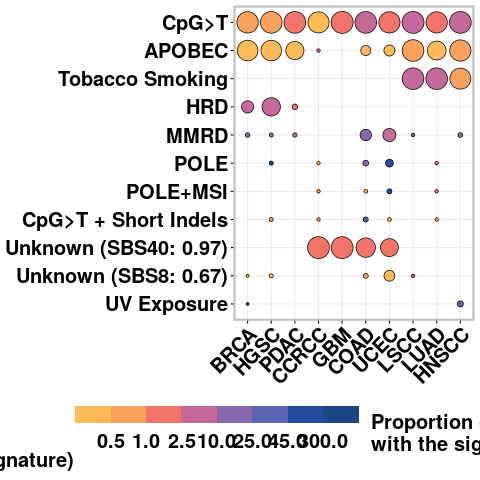

In [163]:
%%R 
summary_df <- summary_df[which(summary_df$frequency.float > 0),]
sigOrder <- c("CpG>T", "APOBEC", "Tobacco Smoking", "HRD", "MMRD", "POLE", 
              "POLE+MSI", "CpG>T + Short Indels", "Unknown (SBS40: 0.97)",
              "Unknown (SBS8: 0.67)", "UV Exposure")
cohortOrder <- c("BRCA", "HGSC", "PDAC", "CCRCC", "GBM", "COAD", "UCEC", "LSCC", "LUAD", "HNSCC")
colorGradient_l <- c("#ffc754", "#faa55d", "#f78765", "#f16a6d", "#cc6998", "#936aae", "#6367b1", "#4d5eaa", "#244da1", "#1d427c")
colorBarBreaks_l <- c(0, 0.5, 1, 2.5, 10, 25, 45, 300)

summary_df$signature <- factor(summary_df$signature, levels=rev(sigOrder), ordered=TRUE)
summary_df$cohort <- factor(summary_df$cohort, levels=cohortOrder, ordered=TRUE)
mut_bubble_plot <- ggpubr::ggballoonplot(
    summary_df,
    x='cohort',
    y="signature",
    fill="median.per.mega",
    size="frequency.float") + 
    scale_fill_stepsn(colours=colorGradient_l, 
                      breaks=colorBarBreaks_l, 
                      values=rescale(colorBarBreaks_l)) +
    labs(x="", y="", fill="Median mutations/Mb due\nto signature\n(among tumors with the signature)", 
         size="Proportion of tumors\nwith the signature") + 
    theme(
        panel.border = element_rect(colour = "grey", fill=NA, size=2),
        legend.position = "bottom", legend.title=element_text(size=20, face="bold"),
        legend.direction="horizontal", legend.key.width = unit(2, "cm"), 
        legend.spacing.x = unit(0.05, "cm"),
        axis.text = element_text(size=20, face="bold", color='black'),
        legend.text = element_text(size=20, face="bold", color='black'),
        legend.justification="left"
    ) + 
    scale_size(range=c(1,10), breaks=c(0.03, 0.1, 0.2, 0.35, 0.5, 0.75, 1))
pdf("figures/Figure_3A_mutational_signatures_bubblemap.pdf", w=10, h=8)
print(mut_bubble_plot)
dev.off()
mut_bubble_plot